In [ ]:
#multi-agent testrun using pettingzoo
#still need to update the actionset
#still need to update reward function
#trial to see if it works

#update the actions so that it selects the frequency range of a particular radar first, and then picks a sub-band from inside it
#fix the frequency hopping of the radar so that it only transmits one frequency per radar per step.

#after finalizing actions and rewards, test on vanilla dqn and sstart implementing ddqn with per

#fixed the radar frquency issue, need to fix the states, obs, info etc tuple being returned by env to the dqn
#after that, train dqn
#finally move to ddqn with per

#created the ddqn with per, need to add multiple radars and finalize
#rn its trying to lock all jammers on to a single radar, which doesnt make sense and is the reason for no convergence

#GRAPH GEN DOES NOT WORK

#ddqn works well on test tho, generalises well to different hop lengths and radar freqs values
#the number of radars to jam is hardcoded as 3 in the env, need to change that to a variable

#FIND OUT HOW A DRQN WORKS AND IMPLEMENT DIAL
#MATHEMATICAL FORMULATION OF THE PROBLEM

In [4]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
from gym import Env
from gym import spaces
import random
from IPython.display import clear_output
import os
import matplotlib
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pettingzoo import ParallelEnv
import seaborn as sns

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#device setup
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [5]:
freq_agile_radar_versions = [[9 * math.pow(10, 9), 9.4* math.pow(10, 9)], [8 * math.pow(10, 9), 8.5* math.pow(10, 9)], [6 * math.pow(10, 9), 6.2* math.pow(10, 9)]]

hop_states = []

for i in range (0,3):
    radar_states = []
    interval = (freq_agile_radar_versions[i][1] - freq_agile_radar_versions[i][0])/10
    for j in range(0,10):
        radar_states.append(int(freq_agile_radar_versions[i][0]+ interval * j))
    hop_states.append(radar_states)

print(hop_states)


[[9000000000, 9040000000, 9080000000, 9120000000, 9160000000, 9200000000, 9240000000, 9280000000, 9320000000, 9360000000], [8000000000, 8050000000, 8100000000, 8150000000, 8200000000, 8250000000, 8300000000, 8350000000, 8400000000, 8450000000], [6000000000, 6020000000, 6040000000, 6060000000, 6080000000, 6100000000, 6120000000, 6140000000, 6160000000, 6180000000]]


In [6]:
jamming_bandwidths = [10e6, 20e6, 30e6]

In [7]:
class ParallelRadarJammingEnv(ParallelEnv):
    def __init__(self, hop_states, jamming_bandwidths, max_hop_length=8):
        super().__init__()

        self.hop_states = hop_states
        self.max_hop_length = max_hop_length

        #params for each hop state list
        self.low = [hop[0] for hop in self.hop_states]
        self.interval = [hop[1] - hop[0] for hop in self.hop_states]
        self.n_frequencies = [len(hop) for hop in self.hop_states]

        #agents
        self.agents = ["jammer_0", "jammer_1", "jammer_2", "jammer_3", "jammer_4", "jammer_5"]
        self.possible_agents = self.agents[:]
        self.agent_name_mapping = {agent: i for i, agent in enumerate(self.agents)}

        #action space
        self.jamming_bandwidths = jamming_bandwidths    
        self.n_bandwidths = len(self.jamming_bandwidths)
        self.action_space = {agent: spaces.Discrete(self.max_hop_length * self.n_bandwidths) for agent in self.agents}

        #observation space
        self.observation_spaces = {
            agent: spaces.Box(low=0, high=1, shape=(sum(self.n_frequencies),), dtype=np.float32) for agent in self.agents
        }

        self.hopping_patterns = None
        self.current_frequencies = None
        self.current_steps = None
        self.cumulative_rewards = None
        self.net_agent_rewards = None
        self.terminations = None
        self.rewards = None
        self.info = None

        
        #jamming fractions
        self.jamming_fractions = None
        self.episode_jamming_success = np.zeros((len(self.hop_states), 200))

    def index_to_action(self, index):
        #action index to freq + bandwidth
        frequency_index = index // self.n_bandwidths
        bandwidth_index = index % self.n_bandwidths
        hop_index = frequency_index % len(self.hop_states)
        frequency = int(self.low[hop_index] + (frequency_index // len(self.hop_states)) * self.interval[hop_index])
        bandwidth = self.jamming_bandwidths[bandwidth_index]
        return frequency, bandwidth

    def generate_hopping_pattern(self):
        return [np.random.choice(hop, self.max_hop_length, replace=False) for hop in self.hop_states]

    def reset(self):
        self.hopping_patterns = self.generate_hopping_pattern()

        # select two unique, non-overlapping frequencies from each pattern
        self.radar_frequencies = [
            [pattern[0], pattern[1]] for pattern in self.hopping_patterns
        ]

        self.current_steps = {agent: 0 for agent in self.agents}
        self.cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.rewards = {agent: 0 for agent in self.agents}
        self.info = {agent: {} for agent in self.agents}

        observations = {agent: self.observe(agent) for agent in self.agents}
        return observations

    def observe(self, agent):
        # observation is a one-hot encoded vector representing the radar frequencies across all hop_states
        observation = np.zeros(sum(self.n_frequencies))
        offset = 0
        for i, frequencies in enumerate(self.hop_states):
            for radar_freq in self.radar_frequencies[i]:  # both frequencies are now represented
                freq_index = np.where(np.array(frequencies) == radar_freq)[0][0]
                observation[offset + freq_index] = 1
            offset += len(frequencies)
        return observation


    def step(self, actions):
        total_jammed_frequencies = 0
        self.net_agent_rewards = 0

        #jamming success rate
        jammed_array = np.zeros_like(self.radar_frequencies)

        for agent, action in actions.items():
            frequency, bandwidth = self.index_to_action(action)
            lower_bound = frequency - bandwidth
            upper_bound = frequency + bandwidth

            jammed = False

            for radar_frequencies in self.radar_frequencies:
                for radar_frequency in radar_frequencies:
                    if lower_bound <= radar_frequency <= upper_bound:
                        jammed = True
                        reward = 30 * ([np.where(np.array(hop) == frequency)[0][0] for hop in self.hop_states if frequency in hop][0] + 1)
                        total_jammed_frequencies += 1
                        #updating jammed array
                        jammed_array[self.radar_frequencies.index(radar_frequencies)][radar_frequencies.index(radar_frequency)] = 1


            if jammed == False:
                reward = -50
                
            for i in range(len(jammed_array)):
                if np.all(jammed_array[i] == 1):
                    self.episode_jamming_success[i][self.current_steps[agent]] = 1

            # if jammed the reward is 30 * (the element of hop_states that the frequency is found in + 1)

            hop_index = np.argmin([abs(frequency - radar[0]) for radar in self.radar_frequencies])

            if 2 * (bandwidth / self.interval[hop_index]) > 5:
                reward -= 10

            jam_threshold = len(self.hop_states[0]) / len(self.agents)
            if total_jammed_frequencies > jam_threshold:
                reward += 5
            else:
                reward -= 5
            
            self.current_steps[agent] += 1
            self.cumulative_rewards[agent] += reward
            self.net_agent_rewards += reward

            # Termination condition after 200 steps
            if self.current_steps[agent] >= 200:
                self.terminations[agent] = True

            self.rewards[agent] = reward

        # Update radar frequencies for the next step with no overlap between two frequencies
        self.radar_frequencies = [
            [
                pattern[self.current_steps[agent] % self.max_hop_length],  # first frequency
                pattern[(self.current_steps[agent] + 2) % self.max_hop_length]  # second frequency ensuring no overlap
            ]
            for pattern in self.hopping_patterns
        ]
        if all(self.terminations.values()):
            self.jamming_fractions = np.sum(self.episode_jamming_success, axis=1) / 200
        
        self.episode_jamming_success = np.zeros_like(self.episode_jamming_success)

        # Return observations, rewards, done status, and info for each agent
        observations = {agent: self.observe(agent) for agent in self.agents}
        rewards = {agent: self.rewards[agent] for agent in self.agents}
        done = {agent: self.terminations[agent] for agent in self.agents}
        info = {agent: self.info[agent] for agent in self.agents}

        return observations, rewards, done, info

    def render(self):
        for agent in self.agents:
            print(f"Agent {agent}, Step: {self.current_steps[agent]}, Radar Frequencies: {self.radar_frequencies}")


In [8]:
env = ParallelRadarJammingEnv(hop_states, jamming_bandwidths)

observations = env.reset()
done = {agent: False for agent in env.agents}
cumulative_reward = {agent: 0 for agent in env.agents}

while not all(done.values()):

    actions = {agent: env.action_space[agent].sample() for agent in env.agents}
    observations, rewards, done, infos = env.step(actions)

    for agent in env.agents:
        cumulative_reward[agent] += rewards[agent]

    env.render()
    print(f"Actions: {actions}, Rewards: {rewards}, Cumulative Rewards: {cumulative_reward}")
    print('\n')


Agent jammer_0, Step: 1, Radar Frequencies: [[9160000000, 9360000000], [8100000000, 8000000000], [6000000000, 6140000000]]
Agent jammer_1, Step: 1, Radar Frequencies: [[9160000000, 9360000000], [8100000000, 8000000000], [6000000000, 6140000000]]
Agent jammer_2, Step: 1, Radar Frequencies: [[9160000000, 9360000000], [8100000000, 8000000000], [6000000000, 6140000000]]
Agent jammer_3, Step: 1, Radar Frequencies: [[9160000000, 9360000000], [8100000000, 8000000000], [6000000000, 6140000000]]
Agent jammer_4, Step: 1, Radar Frequencies: [[9160000000, 9360000000], [8100000000, 8000000000], [6000000000, 6140000000]]
Agent jammer_5, Step: 1, Radar Frequencies: [[9160000000, 9360000000], [8100000000, 8000000000], [6000000000, 6140000000]]
Actions: {'jammer_0': 16, 'jammer_1': 11, 'jammer_2': 17, 'jammer_3': 17, 'jammer_4': 14, 'jammer_5': 20}, Rewards: {'jammer_0': 65, 'jammer_1': 65, 'jammer_2': 65, 'jammer_3': 65, 'jammer_4': 65, 'jammer_5': -45}, Cumulative Rewards: {'jammer_0': 65, 'jammer_1'

In [9]:
#setting up replay memory

Transition = namedtuple('Transition',
('state', 'action', 'next_state', 'reward')
)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

#dqn definition
class DQN(nn.Module):
    def __init__(self, obs_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(obs_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return self.fc6(x)

In [11]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.capacity = capacity
        self.pos = 0
        self.alpha = alpha

    def add(self, state, action, reward, next_state, done):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.pos]

        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        states, actions, rewards, next_states, dones = zip(*samples)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones), indices, np.array(weights))

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def size(self):
        return len(self.buffer)

In [12]:
def update_ddqn(shared_dqn, target_dqn, optimizer, replay_buffer, batch_size, gamma, beta):
    if replay_buffer.size() < batch_size:
        return
    
    #sample from prioritized replay buffer
    states, actions, rewards, next_states, dones, indices, weights = replay_buffer.sample(batch_size, beta)
    
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones).unsqueeze(1)
    weights = torch.FloatTensor(weights).unsqueeze(1)

    #current q-values
    q_values = shared_dqn(states).gather(1, actions)

    #ddqn update rule
    next_actions = shared_dqn(next_states).argmax(1, keepdim=True)
    next_q_values = target_dqn(next_states).gather(1, next_actions)

    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    #weighted MSE loss with importance sampling correction
    td_errors = target_q_values - q_values
    loss = (weights * td_errors ** 2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #update priorities based on new TD errors
    new_priorities = td_errors.abs().detach().numpy() + 1e-5
    replay_buffer.update_priorities(indices, new_priorities)


In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

jamming_fracs_array = np.array([])

#select action
def select_action(state, epsilon, action_size, model):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size) 
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = model(state_tensor)
            return q_values.argmax().item()

#update target fn
def update_target(main_dqn, target_dqn):
    target_dqn.load_state_dict(main_dqn.state_dict())

def train_ddqn_per(env, num_episodes, batch_size, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, 
                   beta_start=0.4, beta_end=1.0, beta_increment_per_episode=0.001, target_update_freq=10, jamming_fracs_array = jamming_fracs_array):

    agent_id = env.agents[0]

    obs_size = env.observation_space(agent_id).shape[0]
    action_size = env.action_space[agent_id].n

    shared_dqn = DQN(obs_size, action_size)
    target_dqn = DQN(obs_size, action_size)
    target_dqn.load_state_dict(shared_dqn.state_dict())

    optimizer = optim.Adam(shared_dqn.parameters(), lr=1e-4)

    replay_buffer = PrioritizedReplayBuffer(10000)

    epsilon = epsilon_start
    beta = beta_start

    total_rewards = []
    mean_rewards = []

    plt.ion()
    plt.figure(figsize=(10, 5))

    for episode in range(num_episodes):
        states = env.reset()
        episode_rewards = {agent: 0 for agent in env.agents}
        done = {agent: False for agent in env.agents}

        while not all(done.values()):
            actions = {}
            for agent in env.agents:
                if not done[agent]:
                    actions[agent] = select_action(states[agent], epsilon, action_size, shared_dqn)

            #env step
            next_states, rewards, dones, _ = env.step(actions)

            #add episode to replay buffer
            for agent in env.agents:
                replay_buffer.add(states[agent], actions[agent], rewards[agent], next_states[agent], dones[agent])
                episode_rewards[agent] += rewards[agent]

            # Update DDQN
            update_ddqn(shared_dqn, target_dqn, optimizer, replay_buffer, batch_size, gamma, beta)

            states = next_states
            done = dones

            #add jamming fractions for each episode
        if all(done.values()):
            if episode == 0:
                jamming_fracs_array = env.jamming_fractions
            else:
                episode_jamming_fractions = env.jamming_fractions
                jamming_fracs_array = np.vstack((jamming_fracs_array,episode_jamming_fractions))


        total_reward = sum(episode_rewards.values())
        total_rewards.append(total_reward)

        #calculate mean rewards for every 100 episodes
        if (episode + 1) % 100 == 0:
            mean_reward = np.mean(total_rewards[-100:])
            mean_rewards.append(mean_reward)
        else:
            mean_rewards.append(mean_rewards[-1] if mean_rewards else 0)

        #decay epsilon and update beta
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        beta = min(beta_end, beta + beta_increment_per_episode)

        #update target dqn
        if episode % target_update_freq == 0:
            update_target(shared_dqn, target_dqn)

        print(f'Episode {episode + 1}: Total reward = {total_reward}')
        #save the weights every 1000 episodes and on the best episode
        if episode % 1000 == 0 or total_reward == max(total_rewards) and total_reward > 0:
            torch.save(shared_dqn.state_dict(), f'ddqn_weights_{episode}.pth')

        #save the best weights
        if total_reward == max(total_rewards) and total_reward > 0:
            torch.save(shared_dqn.state_dict(), 'ddqn_best_weights.pth')

    plt.ioff()
    plt.show()



    return shared_dqn, jamming_fracs_array



In [ ]:
env = ParallelRadarJammingEnv(hop_states, jamming_bandwidths)
ddqn, jamming_fracs_array = train_ddqn_per(env, num_episodes=8000, 
                batch_size=128,
                gamma=0.90, 
                epsilon_start=1, 
                epsilon_end=0.05, 
                epsilon_decay=0.999,
                beta_start=0.3,
                beta_end=1.0, 
                beta_increment_per_episode=0.00005, 
                target_update_freq=40)

c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\pettingzoo\utils\env.py:358: UserWarning: Your environment should override the observation_space function. Attempting to use the observation_spaces dict attribute.
  warnings.warn(


Episode 1: Total reward = -46930
Episode 2: Total reward = -23210
Episode 3: Total reward = -33120
Episode 4: Total reward = -42580
Episode 5: Total reward = -38260
Episode 6: Total reward = -31620
Episode 7: Total reward = -39160
Episode 8: Total reward = -31030
Episode 9: Total reward = -44770
Episode 10: Total reward = -30230


<Figure size 1000x500 with 0 Axes>

In [15]:
#split jamming_fracs array into 3 arrays for each radar
jamming_fracs_array_0 = jamming_fracs_array[:,0]
jamming_fracs_array_1 = jamming_fracs_array[:,1]
jamming_fracs_array_2 = jamming_fracs_array[:,2]

#take the max element per every 100 elements of each array, and add them to a new array

max_jamming_fracs_array_0 = np.array([np.max(jamming_fracs_array_0[i:i+100]) for i in range(0, len(jamming_fracs_array_0), 100)])
max_jamming_fracs_array_1 = np.array([np.max(jamming_fracs_array_1[i:i+100]) for i in range(0, len(jamming_fracs_array_1), 100)])
max_jamming_fracs_array_2 = np.array([np.max(jamming_fracs_array_2[i:i+100]) for i in range(0, len(jamming_fracs_array_2), 100)])

c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

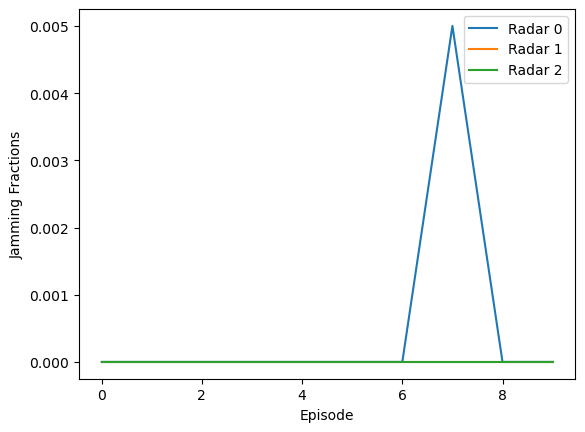

In [16]:
sns.lineplot(jamming_fracs_array_0, label='Radar 0')
sns.lineplot(jamming_fracs_array_1, label='Radar 1')
sns.lineplot(jamming_fracs_array_2, label='Radar 2')
plt.xlabel('Episode')
plt.ylabel('Jamming Fractions')
plt.legend()
plt.show()

In [23]:
#test the trained model with some epsilon greedy policy

def test_model(env, model, num_episodes=10):

    agent_id = env.agents[0]
    obs_size = env.observation_space(agent_id).shape[0]
    action_size = env.action_space[agent_id].n

    total_rewards = []

    for episode in range(num_episodes):
        states = env.reset()
        episode_rewards = {agent: 0 for agent in env.agents}
        done = {agent: False for agent in env.agents}

        while not all(done.values()):
            actions = {}
            for agent in env.agents:
                if not done[agent]:
                    state = torch.FloatTensor(states[agent]).unsqueeze(0)
                    q_values = model(state)
                    actions[agent] = q_values.argmax().item()

            next_states, rewards, dones, _ = env.step(actions)

            for agent in env.agents:
                episode_rewards[agent] += rewards[agent]

            states = next_states
            done = dones

        total_reward = sum(episode_rewards.values())
        total_rewards.append(total_reward)

        print(f'Episode {episode + 1}: Total reward = {total_reward}')

    return total_rewards

In [33]:
test_radar = [[5 * math.pow(10, 9), 5.4* math.pow(10, 9)], [4 * math.pow(10, 9), 4.5* math.pow(10, 9)], [7 * math.pow(10, 9), 7.2* math.pow(10, 9)]]

hop_states_test = []

for i in range (0,3):
    radar_states_test = []
    interval_test = (test_radar[i][1] - test_radar[i][0])/10
    for j in range(0,10):
        radar_states_test.append(int(test_radar[i][0]+ interval_test * j))
    hop_states_test.append(radar_states_test)


In [34]:
#load the best weights and test the model

ddqn.load_state_dict(torch.load('ddqn_weights_3632.pth'))
ddqn.eval()
env = ParallelRadarJammingEnv(hop_states_test, jamming_bandwidths, max_hop_length=10)
rewards = test_model(env, ddqn, num_episodes=50)

print(f'Mean reward = {np.mean(rewards)}')

Episode 1: Total reward = 72600
Episode 2: Total reward = 87180
Episode 3: Total reward = 86800
Episode 4: Total reward = 76380
Episode 5: Total reward = 76380
Episode 6: Total reward = 55890
Episode 7: Total reward = 72600
Episode 8: Total reward = 87020
Episode 9: Total reward = 87000
Episode 10: Total reward = 68110
Episode 11: Total reward = 86810
Episode 12: Total reward = 69180
Episode 13: Total reward = 62360
Episode 14: Total reward = 62180
Episode 15: Total reward = 39890
Episode 16: Total reward = 86980
Episode 17: Total reward = 76200
Episode 18: Total reward = 61800
Episode 19: Total reward = 65400
Episode 20: Total reward = 75490
Episode 21: Total reward = 58400
Episode 22: Total reward = 86980
Episode 23: Total reward = 83200
Episode 24: Total reward = 55510
Episode 25: Total reward = 44380
Episode 26: Total reward = 69180
Episode 27: Total reward = 79960
Episode 28: Total reward = 72600
Episode 29: Total reward = 40420
Episode 30: Total reward = 62710
Episode 31: Total r